In [ ]:
#Avuç izi roi aktarımı-----------------------------------------

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import os
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [13]:
#TRAIN ROI

In [ ]:
train_dir =  'Dataset/Train/'
train_paths = []
for label in os.listdir(train_dir):
    for file in os.listdir(train_dir+label):
        images = train_paths.append(train_dir+label+'/'+file)
train_paths.sort()
train_paths

1.Adım ----- CHVD algoritması: Avuç içi ve komşularının 𝑁 sınırındaki bir nokta göz önüne alındığında, el olmayan bölgede 𝑀'den fazla komşu yoksa, söz konusu nokta içbükey bir nokta olarak kabul edilir.

2.Adım ----- Gürültüyü gidermek için Gauss yumuşatma kullanıldı. Daha kesin ikilileştirme için eklemleri aydınlatmak için logaritmaya dönüştürüldü.
Avuç içi alanını arka plandan ayırmak için Otsu eşikleme kullanıldı.

3.Adım ----- Konturları çıkarma: logaritmik dönüşüm bazı arka plan alanlarını aydınlattığı için, Otsu eşikleme de bu alanları yanlışlıkla el alanları olarak tanır. Ancak asıl el alanı en geniş alana sahip alandır, sadece bu alanın konturunu çıkarmamız gerekiyor.

4.Adım ----- Orta nokta bulma: Orta nokta, konturların ortalaması alınarak kolayca bulunabilir.

5.Adım ----- Kontur üzerindeki her noktadan ağırlık merkezine olan Öklid mesafesini hesaplandı.Örtüşme nedeniyle gürültüyü gidermek için bu mesafe aralığı için alçak geçiren filtre eklendi. Yerel minimumu bulmak için türev kullanılır.

6.Adım ----- Görüntüyü döndürülür: ROI bölgesinin çıkarılmasına hazırlanmak için iki özel çöküntüyü birleştiren çizgi dikey olacak şekilde görüntü döndürüldü.

7.Adım ----- ROI ayıklama: İki özel girintiyi birleştiren çizginin uzunluğuna ve konumuna göre ROI bölgesini çerçevele ve çıkar.

In [ ]:
def PalmROI(path, output):
    global Thresh
    global filepath
    filepath = path

    blurSigma = 1.0
    otsuThreshold = 0
    freqThreshold = 10
    neighborDistance = 50

    angle = np.array([0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5])
    angle = angle * np.pi / 180

    sin = np.sin(angle)
    cos = np.cos(angle)

    d = np.array([neighborDistance, 0])
    delta = np.zeros((16, 2))

    for i in range(16):
        delta[i] = np.dot(np.array([[cos[i], -sin[i]], [sin[i], cos[i]]]), d)

    def nonValleySuppression(img, candidate):
        rows, cols = img.shape
        newCandidate = np.zeros((0, 2))

        for c in candidate:
            neighbor = np.round(c + delta).astype(np.int64)
            neighbor = neighbor[(neighbor[:, 1] >= 0) & (neighbor[:, 1] < rows) & (neighbor[:, 0] >= 0) & (neighbor[:, 0] < cols)]
            value = img[neighbor[:, 1], neighbor[:, 0]]

            count = np.sum(value == 0)
            if count <= 7:
                newCandidate = np.append(newCandidate, c.reshape(1, 2).astype(np.int64), axis = 0)
        return newCandidate

    i=0
    for filepath in filepath:
        original = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            original = cv2.resize(original,(1024,1024))
        except:
            print("Hata")
        # Smoothing
        blurred = cv2.GaussianBlur(original, (0, 0), blurSigma)

        # Lightening
        c = 255 / np.log(np.max(blurred) + 1)
        enhanced = (c * np.log(blurred + 1)).astype(np.uint8)

        # Thresholding
        retval, thresholded = cv2.threshold(enhanced, otsuThreshold, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2:]

        area = [cv2.contourArea(contour) for contour in contours]

        order = np.argmax(area)
        contour = contours[order]

        boundary = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(boundary, contour, -1, (255, 0, 0), 3)


        moments = cv2.moments(contour)
        center = [moments['m10'] // moments['m00'], moments['m01'] // moments['m00']]


        # Calculating distances
        contour = contour[:, 0, :]
        distance = np.sqrt(np.sum((contour - center) ** 2, axis = 1)).reshape(-1)

        # Low-pass filtering
        freq = np.fft.rfft(distance)
        newFreq = np.concatenate([freq[:freqThreshold], 0 * freq[freqThreshold:]])
        newDistance = np.fft.irfft(newFreq)

        # Derivation
        derivation = np.diff(newDistance)
        zeroCrossing = np.diff(np.sign(derivation)) / 2

        # Local minima
        candidate = contour[np.where(zeroCrossing > 0)[0]]

        # CHVD algorithm
        candidate = nonValleySuppression(thresholded, candidate)

        # Three left most valleys
        order = np.argsort(candidate[:, 0])
        candidate = candidate[order]
        candidate = candidate[:3]
        
        # Top and bottom valleys of the triad
        order = np.argsort(candidate[:, 1])
        valley = candidate[[order[0], order[2]]]

        valley0, valley1 = valley
        phi = - 90 + np.arctan2((valley1 - valley0)[1], (valley1 - valley0)[0]) * 180 / np.pi

        R = cv2.getRotationMatrix2D(tuple(center), phi, 1)
        rotated = cv2.warpAffine(original, R, original.shape[::-1])

        valley0 = (np.dot(R[:, :2], valley0) + R[:, -1]).astype(np.int)
        valley1 = (np.dot(R[:, :2], valley1) + R[:, -1]).astype(np.int)

        rect0 = (valley0[0] + 2 * (valley1[1] - valley0[1]) // 6, valley0[1] - (valley1[1] - valley0[1]) // 6)
        rect1 = (valley1[0] + 10 * (valley1[1] - valley0[1]) // 6, valley1[1] + (valley1[1] - valley0[1]) // 6)

        marked = cv2.cvtColor(rotated, cv2.COLOR_GRAY2BGR)
        cv2.rectangle(marked, rect0, rect1, (255, 0, 0), 3)

        roiGray = rotated[rect0[1]:rect1[1], rect0[0]:rect1[0]]
        roiNormal = cv2.cvtColor(roiGray, cv2.COLOR_BGR2RGB)

        grayCPY = cv2.cvtColor(roiNormal, cv2.COLOR_BGR2GRAY)
        noise = cv2.fastNlMeansDenoising(grayCPY)
        noise = cv2.cvtColor(noise, cv2.COLOR_GRAY2BGR)

          # equalist hist
        kernel = np.ones((7,7),np.uint8)
        img = cv2.morphologyEx(noise, cv2.MORPH_OPEN, kernel)
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)


        # invert
        inv = cv2.bitwise_not(img_output)

        # erode
        grayCPY = cv2.cvtColor(inv, cv2.COLOR_BGR2GRAY)
        erosion = cv2.erode(grayCPY,kernel,iterations = 1)

        # skel
        img = grayCPY.copy()
        skel = img.copy()
        skel[:,:] = 0
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))
        iterations = 0
        #print("dongu")
        while True:
            eroded = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
            temp = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel)
            temp  = cv2.subtract(img, temp)
            skel = cv2.bitwise_or(skel, temp)
            img[:,:] = eroded[:,:]
            if cv2.countNonZero(img) == 0:
                break

        ret, Thresh = cv2.threshold(skel, 5,255, cv2.THRESH_BINARY);
        Thresh = cv2.resize(Thresh, (224,224))
        roiNormal = cv2.resize(roiNormal, (224,224))
        fig, aarr = plt.subplots(1, 2)
        aarr[0].imshow(roiNormal, cmap = "gray")
        aarr[0].set_title("Normal ROI")
        aarr[0].axis("off")
        aarr[1].imshow(Thresh)
        aarr[1].set_title("Thresh ROI")
        aarr[1].axis("off")
        if i == 7:
            i = 0
        cv2.imwrite(output + filepath[18:27] + str(i+1) + '.JPG', Thresh)
        #print("saa")
        print(filepath)
        print("-----------------------")
        i=i+1
        plt.show()


try:
    op = 'Dataset/TrainWithROI/'
    PalmROI(train_paths, op)
    print("Palm ROI Aktarımı Başarılı")
except:
    print("Hatalı")

In [29]:
#TEST ROI

In [ ]:
test_dir = 'Dataset/Test/'
test_paths = []
for label in os.listdir(test_dir):
    for file in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+file)
test_paths.sort()
test_paths

In [ ]:
def PalmROI(path, output):
    global Thresh
    global filepath
    filepath = path

    blurSigma = 1.0
    otsuThreshold = 0
    freqThreshold = 10
    neighborDistance = 50

    angle = np.array([0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5])
    angle = angle * np.pi / 180

    sin = np.sin(angle)
    cos = np.cos(angle)

    d = np.array([neighborDistance, 0])
    delta = np.zeros((16, 2))

    for i in range(16):
        delta[i] = np.dot(np.array([[cos[i], -sin[i]], [sin[i], cos[i]]]), d)

    def nonValleySuppression(img, candidate):
        rows, cols = img.shape
        newCandidate = np.zeros((0, 2))

        for c in candidate:
            neighbor = np.round(c + delta).astype(np.int64)
            neighbor = neighbor[(neighbor[:, 1] >= 0) & (neighbor[:, 1] < rows) & (neighbor[:, 0] >= 0) & (neighbor[:, 0] < cols)]
            value = img[neighbor[:, 1], neighbor[:, 0]]

            # Determine whether a hand-valley or not
            count = np.sum(value == 0)
            if count <= 7:
                newCandidate = np.append(newCandidate, c.reshape(1, 2).astype(np.int64), axis = 0)
        return newCandidate

    i=0
    for filepath in filepath:
        original = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            original = cv2.resize(original,(1024,1024))
        except:
            print("Hata")
        # Smoothing
        blurred = cv2.GaussianBlur(original, (0, 0), blurSigma)

        # Lightening
        c = 255 / np.log(np.max(blurred) + 1)
        enhanced = (c * np.log(blurred + 1)).astype(np.uint8)

        # Thresholding
        retval, thresholded = cv2.threshold(enhanced, otsuThreshold, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2:]

        area = [cv2.contourArea(contour) for contour in contours]

        order = np.argmax(area)
        contour = contours[order]

        boundary = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(boundary, contour, -1, (255, 0, 0), 3)

        moments = cv2.moments(contour)
        center = [moments['m10'] // moments['m00'], moments['m01'] // moments['m00']]

        # Calculating distances
        contour = contour[:, 0, :]
        distance = np.sqrt(np.sum((contour - center) ** 2, axis = 1)).reshape(-1)

        # Low-pass filtering
        freq = np.fft.rfft(distance)
        newFreq = np.concatenate([freq[:freqThreshold], 0 * freq[freqThreshold:]])
        newDistance = np.fft.irfft(newFreq)

        # Derivation
        derivation = np.diff(newDistance)
        zeroCrossing = np.diff(np.sign(derivation)) / 2

        # Local minima
        candidate = contour[np.where(zeroCrossing > 0)[0]]

        # CHVD algorithm
        candidate = nonValleySuppression(thresholded, candidate)

        # Three left most valleys
        order = np.argsort(candidate[:, 0])
        candidate = candidate[order]
        candidate = candidate[:3]
        
        # Top and bottom valleys of the triad
        order = np.argsort(candidate[:, 1])
        valley = candidate[[order[0], order[2]]]

        valley0, valley1 = valley
        phi = - 90 + np.arctan2((valley1 - valley0)[1], (valley1 - valley0)[0]) * 180 / np.pi

        R = cv2.getRotationMatrix2D(tuple(center), phi, 1)
        rotated = cv2.warpAffine(original, R, original.shape[::-1])

        valley0 = (np.dot(R[:, :2], valley0) + R[:, -1]).astype(np.int)
        valley1 = (np.dot(R[:, :2], valley1) + R[:, -1]).astype(np.int)

        rect0 = (valley0[0] + 2 * (valley1[1] - valley0[1]) // 6, valley0[1] - (valley1[1] - valley0[1]) // 6)
        rect1 = (valley1[0] + 10 * (valley1[1] - valley0[1]) // 6, valley1[1] + (valley1[1] - valley0[1]) // 6)

        marked = cv2.cvtColor(rotated, cv2.COLOR_GRAY2BGR)
        cv2.rectangle(marked, rect0, rect1, (255, 0, 0), 3)

        roiGray = rotated[rect0[1]:rect1[1], rect0[0]:rect1[0]]
        roiNormal = cv2.cvtColor(roiGray, cv2.COLOR_BGR2RGB)

        grayCPY = cv2.cvtColor(roiNormal, cv2.COLOR_BGR2GRAY)
        noise = cv2.fastNlMeansDenoising(grayCPY)
        noise = cv2.cvtColor(noise, cv2.COLOR_GRAY2BGR)

        # equalist hist
        kernel = np.ones((7,7),np.uint8)
        img = cv2.morphologyEx(noise, cv2.MORPH_OPEN, kernel)
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)


        # invert
        inv = cv2.bitwise_not(img_output)

        # erode
        grayCPY = cv2.cvtColor(inv, cv2.COLOR_BGR2GRAY)
        erosion = cv2.erode(grayCPY,kernel,iterations = 1)

        # skel
        img = grayCPY.copy()
        skel = img.copy()
        skel[:,:] = 0
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))
        iterations = 0
        #print("dongu")
        while True:
            eroded = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
            temp = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel)
            temp  = cv2.subtract(img, temp)
            skel = cv2.bitwise_or(skel, temp)
            img[:,:] = eroded[:,:]
            if cv2.countNonZero(img) == 0:
                break

        ret, Thresh = cv2.threshold(skel, 5,255, cv2.THRESH_BINARY);
        Thresh = cv2.resize(Thresh, (224,224))
        roiNormal = cv2.resize(roiNormal, (224,224))
        fig, aarr = plt.subplots(1, 2)
        aarr[0].imshow(roiNormal, cmap = "gray")
        aarr[0].set_title("Normal ROI")
        aarr[0].axis("off")
        aarr[1].imshow(Thresh)
        aarr[1].set_title("Thresh ROI")
        aarr[1].axis("off")
        if i == 3:
            i = 0
        cv2.imwrite(output + filepath[17:25] + str(i+1) + '.JPG', Thresh)
        #print("saa")
        print(filepath)
        print("-----------------------")
        i=i+1
        plt.show()

try:
    op = 'Dataset/TestWithROI/'
    PalmROI(test_paths, op)
except:
    print("Hatalı")
print("Palm ROI Aktarımı Başarılı")

In [ ]:
#MODEL EĞİTME----------------------------------------------- DÜZENLENMİŞ RESİMLERİ AKTAR

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow.keras
from keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [27]:
train_dir =  'Dataset/TrainWithROI/'
train_paths = []
for label in os.listdir(train_dir):
    for file in os.listdir(train_dir+label):
        images = train_paths.append(train_dir+label+'/'+file)
print(len(train_paths))

714


In [28]:
test_dir = 'Dataset/TestWithROI/'
test_paths = []
for label in os.listdir(test_dir):
    for file in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+file)
print(len(test_paths))

306


In [29]:
labels = os.listdir(train_dir)
labels.sort()
print(len(labels))

102


In [30]:
def open_images(path):
    image = load_img(path, color_mode = "grayscale")
    image = np.array(image)/255.0
    return image

def get_labels(path):
    path = path.split('/')[-2]
    return path

def data_gen(data_paths):
    img=[]
    lab=[]
    for i in range(0, len(data_paths)):
        paths = data_paths[i]
        images = open_images(paths)
        img.append(open_images(paths).reshape(224, 224, 1))
        labels = get_labels(paths)
        lab.append(get_labels(paths))

        #yield images,np.array(labels)
    return np.array(img) , np.array(lab)

In [31]:
model1 = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224, 224, 1)),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tensorflow.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tensorflow.keras.layers.Flatten(),
    tensorflow.keras.layers.Dense(4096, activation='relu'),
    tensorflow.keras.layers.Dropout(0.5),
    tensorflow.keras.layers.Dense(4096, activation='relu'),
    tensorflow.keras.layers.Dropout(0.5),
    tensorflow.keras.layers.Dense(2048, activation='relu'),
    tensorflow.keras.layers.Dropout(0.5),
    tensorflow.keras.layers.Dense(1000, activation='relu'),
    tensorflow.keras.layers.Dropout(0.5),
    tensorflow.keras.layers.Dense(len(labels) + 1, activation='softmax')
])
batch_size = 32
epochs = 50
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 54, 54, 32)        3904      
                                                                 
 batch_normalization_5 (Batc  (None, 54, 54, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 64)        51264     
                                                                 
 batch_normalization_6 (Batc  (None, 26, 26, 64)       256       
 hNormalization)                                                 
                                                      

In [32]:
X_train, y_train = data_gen(train_paths)
X_test, y_test = data_gen(test_paths)

In [33]:
train_data  =X_train
train_labels_one_hot = to_categorical(y_train)
test_data = X_test
test_labels_one_hot = to_categorical(y_test)

history = model1.fit(train_data, 
                     train_labels_one_hot, 
                     batch_size=batch_size, 
                     epochs=epochs, 
                     verbose=1, 
                    validation_data=(test_data, test_labels_one_hot))


model1.evaluate(test_data, test_labels_one_hot)

Epoch 1/50
23/23 [==============================] - 35s 1s/step - loss: 43.8886 - accuracy: 0.0056 - val_loss: 4.7748 - val_accuracy: 0.0098
Epoch 2/50
23/23 [==============================] - 28s 1s/step - loss: 4.8571 - accuracy: 0.0266 - val_loss: 8.1443 - val_accuracy: 0.0098
Epoch 3/50
23/23 [==============================] - 29s 1s/step - loss: 4.8110 - accuracy: 0.0140 - val_loss: 9.1545 - val_accuracy: 0.0098
Epoch 4/50
23/23 [==============================] - 27s 1s/step - loss: 4.8263 - accuracy: 0.0168 - val_loss: 22.0518 - val_accuracy: 0.0098
Epoch 5/50
23/23 [==============================] - 28s 1s/step - loss: 4.8744 - accuracy: 0.0098 - val_loss: 31.1813 - val_accuracy: 0.0098
Epoch 6/50
23/23 [==============================] - 28s 1s/step - loss: 4.6001 - accuracy: 0.0224 - val_loss: 40.0720 - val_accuracy: 0.0098
Epoch 7/50
23/23 [==============================] - 27s 1s/step - loss: 4.4931 - accuracy: 0.0406 - val_loss: 23.8915 - val_accuracy: 0.0131
Epoch 8/50
23/2

[1.0526680946350098, 0.898692786693573]

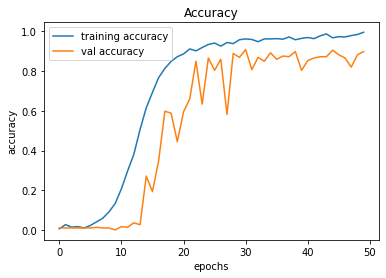

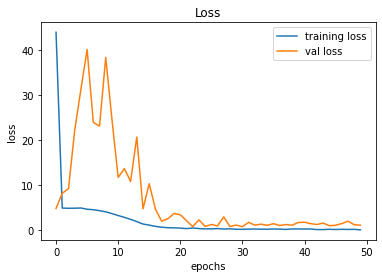

In [34]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title("Accuracy")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
sample_no = 0
for sample_no in range(0, len(test_paths)):
    predicted = model1.predict(X_test[sample_no].reshape(-1,224,224,1))[0]
    predicted.sort()
    label = test_paths[sample_no].split('/')[-2]
    print("Tahmin: " , np.argmax(model1.predict(X_test[sample_no].reshape(-1,224,224,1))[0]))
    print('Gerçek:', label)
    print("Doğruluk Oranı -- 1:", format(predicted[-1], '.8f'))
    print("Doğruluk Oranı -- 2:", format(predicted[-2], '.8f'))
    print("Doğruluk Oranı -- 3:", format(predicted[-3], '.8f'))
    print("-----------------------------------------------")